In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.proportion as proportion
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot
import ssl
import plotly_express as px
import json
import urllib3
import certifi
import sqlite3

<IPython.core.display.Javascript object>

In [5]:
# Read from games table to create three DFs: all_games, home_wins, away_wins

conn = sqlite3.connect("NCAAF.db")

c = conn.cursor()

all_games = pd.read_sql_query("SELECT * FROM games ", conn)
all_games["W/L"] = np.where(all_games["home_score"] > all_games["away_score"], "W", "L")
all_games.drop(columns=["home_offense_plays", "away_offense_plays"], inplace=True)

home_wins = pd.read_sql_query(
    "SELECT * FROM games WHERE games.home_score>games.away_score", conn
)

away_wins = pd.read_sql_query(
    "SELECT * FROM games WHERE games.home_score<games.away_score", conn
)

<IPython.core.display.Javascript object>

### Research question
What is the statistical significance of statistics which measure the five factors of college football to winning and losing?

### The five factors of college football
* Explosiveness
* Efficiency
* Field position
* Finishing drives
* Turnovers

### Stats to measure the five factors
* ypp: yards per play
* success_rate: successful plays/total plays
    * What is a successful play?
        * On first down: Gaining half of the required yards to gain a first down
        * On second down: Gaining 70 percent of the required yards to gain a first down
        * On third/fourth down: Gaining all of the required yards to gain a frist down
* ppapsp: Projected points added per succesful play
* afp: Average starting field position
* ppti40: Points per trip inside the 40 yard line
* turnovers: turnovers/plays

### Hypothesis

x1= `home_wins feature`\
x2= `away_wins feature`\
\
For each feature:\
H<sub>o</sub>: `mean(x1) - mean(x2) = 0`

H<sub>a</sub>: `mean(x1) - mean(x2) != 0`

### Data
* all_games
    * DF with stats from 4046 games from 2014-2019
* home_wins
    * DF containing data from only wins by home team
* away_wins
    * DF containing data from only wins by away team

In [43]:
all_games.head()

,game_id,year,week,home_team,away_team,home_ypp,home_success_rate,home_ppapsp,home_afp,home_ppti40,home_turnovers,away_ypp,away_success_rate,away_ppapsp,away_afp,away_ppti40,away_turnovers,home_score,away_score,W/L
0,400603840,2015,1,South Carolina,North Carolina,4.425,0.388,0.432,31.818,4.250,0.000,6.100,0.400,0.439,22.800,2.167,0.043,17,13,W
1,400763593,2015,1,UCF,Florida International,4.353,0.382,0.522,33.727,2.800,0.000,4.743,0.338,0.410,18.167,4.250,0.014,14,15,L
2,400763399,2015,1,Central Michigan,Oklahoma State,4.392,0.378,0.425,20.917,4.333,0.014,5.620,0.394,0.434,30.000,4.000,0.000,13,24,L
3,400756896,2015,1,Wake Forest,Elon,7.190,0.488,0.579,26.000,4.556,0.000,2.385,0.135,0.146,25.167,3.000,0.000,41,3,W
4,400787299,2015,1,Ball State,VMI,5.290,0.480,0.510,41.067,4.800,0.010,6.524,0.369,0.596,22.071,5.429,0.000,48,36,W


<IPython.core.display.Javascript object>

In [42]:
home_wins.head()

,game_id,year,week,home_team,away_team,home_ypp,home_success_rate,home_ppapsp,home_afp,home_ppti40,...,away_ypp,away_success_rate,away_ppapsp,away_afp,away_ppti40,away_turnovers,home_offense_plays,away_offense_plays,home_score,away_score
0,400603840,2015,1,South Carolina,North Carolina,4.425,0.388,0.432,31.818,4.250,...,6.100,0.400,0.439,22.800,2.167,0.043,80,70,17,13
1,400756896,2015,1,Wake Forest,Elon,7.190,0.488,0.579,26.000,4.556,...,2.385,0.135,0.146,25.167,3.000,0.000,84,52,41,3
2,400787299,2015,1,Ball State,VMI,5.290,0.480,0.510,41.067,4.800,...,6.524,0.369,0.596,22.071,5.429,0.000,100,84,48,36
3,400764854,2015,1,Connecticut,Villanova,5.016,0.476,0.512,26.300,4.200,...,3.972,0.389,0.460,26.800,2.800,0.014,63,72,20,15
4,400756895,2015,1,Georgia Tech,Alcorn State,10.228,0.684,0.963,42.462,7.000,...,3.222,0.278,0.309,34.857,2.333,0.042,57,72,69,6


<IPython.core.display.Javascript object>

In [44]:
away_wins.head()

,game_id,year,week,home_team,away_team,home_ypp,home_success_rate,home_ppapsp,home_afp,home_ppti40,...,away_ypp,away_success_rate,away_ppapsp,away_afp,away_ppti40,away_turnovers,home_offense_plays,away_offense_plays,home_score,away_score
0,400763593,2015,1,UCF,Florida International,4.353,0.382,0.522,33.727,2.800,...,4.743,0.338,0.410,18.167,4.250,0.014,68,74,14,15
1,400763399,2015,1,Central Michigan,Oklahoma State,4.392,0.378,0.425,20.917,4.333,...,5.620,0.394,0.434,30.000,4.000,0.000,74,71,13,24
2,400603839,2015,1,Vanderbilt,Western Kentucky,4.612,0.375,0.399,34.417,1.857,...,4.268,0.375,0.379,27.615,4.667,0.000,80,56,12,14
3,400763398,2015,1,Minnesota,TCU,4.167,0.385,0.355,22.667,4.250,...,4.469,0.448,0.416,35.000,2.875,0.021,78,96,17,23
4,400787302,2015,1,Idaho,Ohio,4.550,0.525,0.441,31.917,5.400,...,6.465,0.479,0.575,46.909,5.000,0.000,80,71,28,45


<IPython.core.display.Javascript object>

### Test for normality of the distributions of the features
Before testing for statistcal signifance, we must determine if the distributions for each feature are normal or not.

In [13]:
features = [
    "home_ypp",
    "home_success_rate",
    "home_ppapsp",
    "home_afp",
    "home_ppti40",
    "home_turnovers",
    "away_ypp",
    "away_success_rate",
    "away_ppapsp",
    "away_afp",
    "away_ppti40",
    "away_turnovers",
]

# Describe the distributions of each feature in the home_wins DF
for feature in features:
    home_wins_desc = stats.describe(home_wins[feature])
    print(feature, "\n")
    print("Variance: ", home_wins_desc[3])
    print("Skewness: ", home_wins_desc[4])
    print("Kurtosis: ", home_wins_desc[5])
    print("-" * 24, "\n")

home_ypp 

Variance:  2.0960641859561147
Skewness:  0.5392012682373369
Kurtosis:  0.7800094419816421
------------------------ 

home_success_rate 

Variance:  0.006641649032706628
Skewness:  0.13489183419669495
Kurtosis:  -0.10963783304690988
------------------------ 

home_ppapsp 

Variance:  0.01679808099416452
Skewness:  0.4938338425716846
Kurtosis:  0.8035621522643122
------------------------ 

home_afp 

Variance:  37.89640938362801
Skewness:  0.38655239275308484
Kurtosis:  0.7254853414492222
------------------------ 

home_ppti40 

Variance:  1.2347213388973803
Skewness:  -0.3391013138506352
Kurtosis:  -0.015505996529882271
------------------------ 

home_turnovers 

Variance:  0.00016265503713486522
Skewness:  1.0842869975984746
Kurtosis:  1.3278299868326666
------------------------ 

away_ypp 

Variance:  1.7833888059094272
Skewness:  0.04579621582127414
Kurtosis:  0.2836764135413241
------------------------ 

away_success_rate 

Variance:  0.006939279649772343
Skewness:  -0.16

<IPython.core.display.Javascript object>

The skewness and kurtosis of most of the features doesn't seem to be a problem. Let's visualize the distributions and see for ourselves.

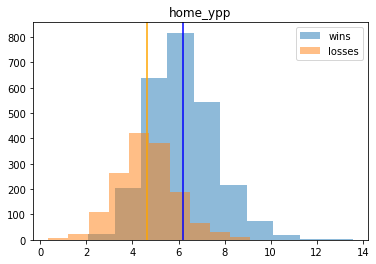

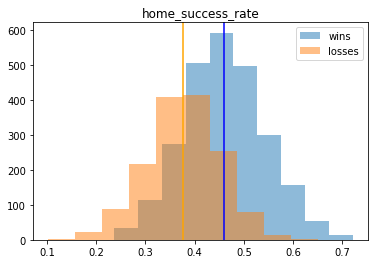

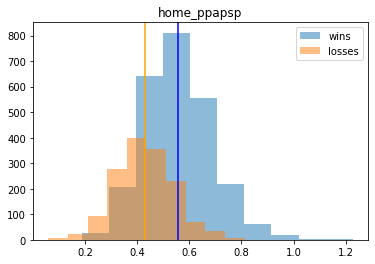

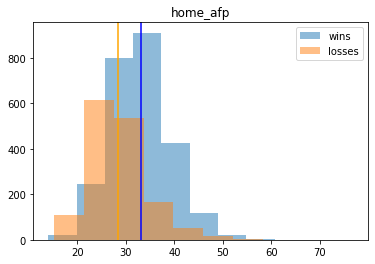

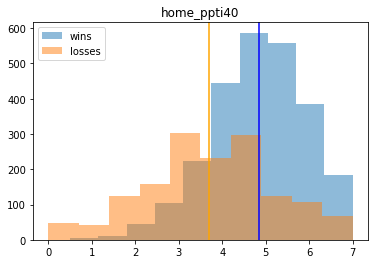

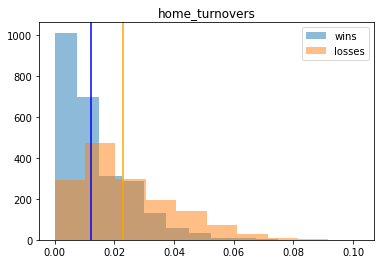

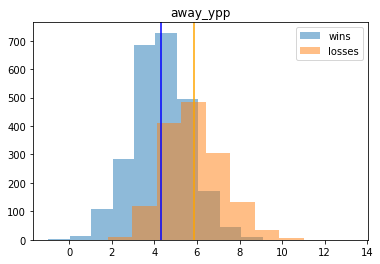

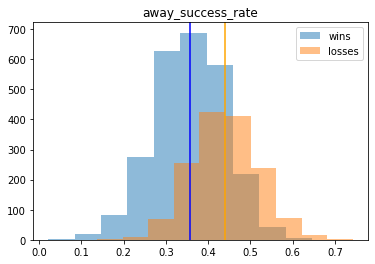

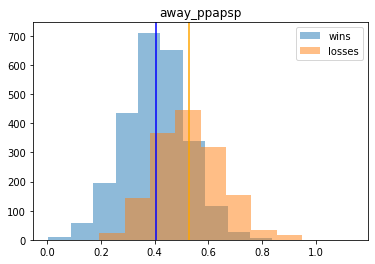

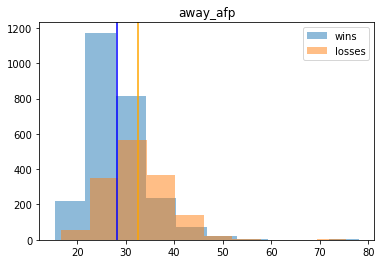

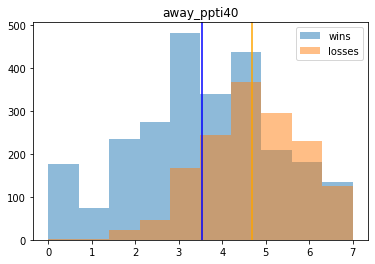

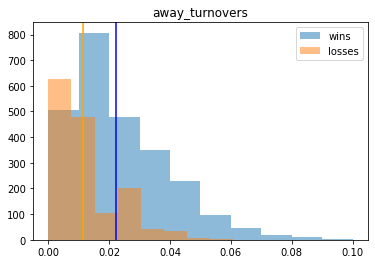

<IPython.core.display.Javascript object>

In [15]:
# Visualize histograms of distributions for each feature and compare the means
# Wins and losses are from the prespective of the home team
# A win is a win for the home team and a loss is a win for the away team
for feature in features:
    plt.hist(home_wins[feature], alpha=0.5, label="wins")
    plt.hist(away_wins[feature], alpha=0.5, label="losses")
    plt.axvline(home_wins[feature].mean(), c="blue")
    plt.axvline(away_wins[feature].mean(), c="orange")
    plt.legend()
    plt.title(feature)
    plt.show()

From our histograms we can see there is a noticible difference of means for each feature between wins and losses.\
\
Most of the features appear to have normal distributions with the exception of *turnover rate* and *average field position*. \
\
It is also interesting to see that the size of the distributions of wins (home wins) is much greater than losses (away wins). **How often does the home team win?**

In [18]:
print("Home win rate: ", round(len(home_wins) / len(all_games), 2))

Home win rate:  0.63


<IPython.core.display.Javascript object>

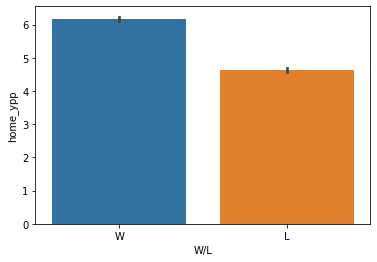

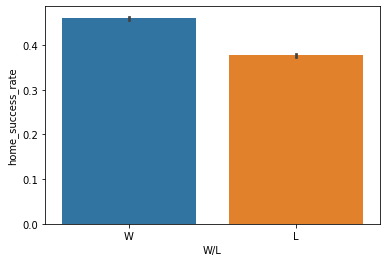

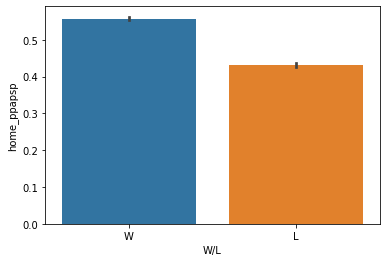

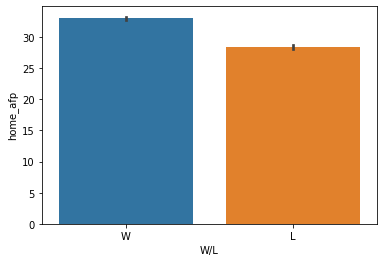

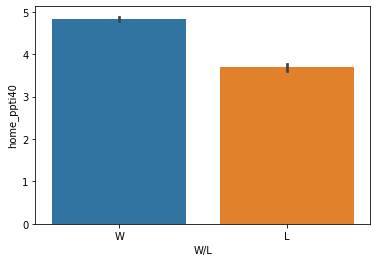

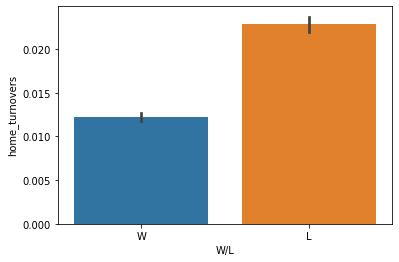

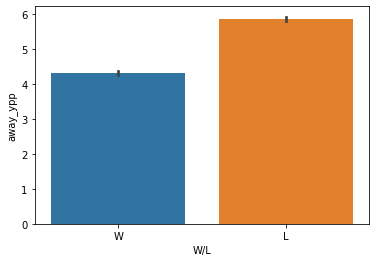

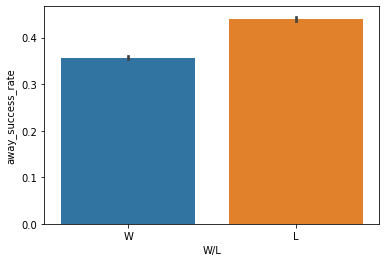

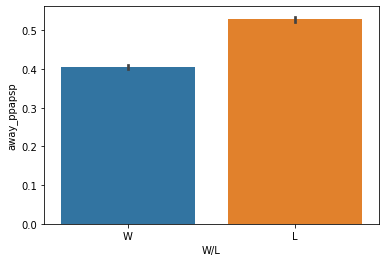

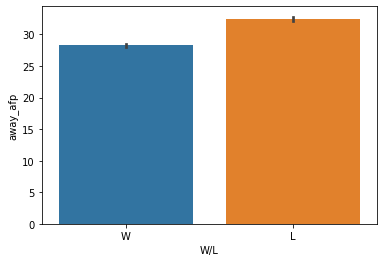

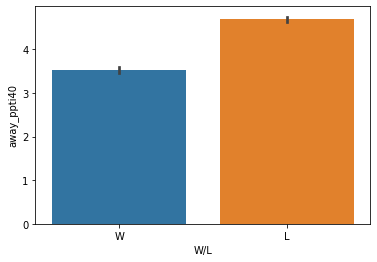

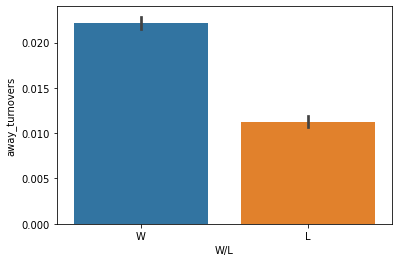

<IPython.core.display.Javascript object>

In [46]:
# Bar plots for each feature to further visualize the difference in means.

for feature in features:
    sns.barplot(x="W/L", y=feature, data=all_games)
    plt.show()

In [27]:
# Seperate the features between normal and non-normal distributions
normal_dists = [
    "home_ypp",
    "home_success_rate",
    "home_ppapsp",
    "home_ppti40",
    "away_ypp",
    "away_success_rate",
    "away_ppapsp",
    "away_ppti40",
]

non_normal_dists = [i for i in features if i not in normal_dists]

<IPython.core.display.Javascript object>

### Test for statistcal signifance
After determining which distributions are normal and non-normal we can run the appropriate tests to find the statistcal significance.\
\
For features with normal distributions, we will perform an indpendent T-test and find the confidence intervals at a 95% confidence level.\
\
For features with non-normal distributions, we will perform a chi-squared test and find the confidence interval.

In [47]:
# Perform independent T-tests and find confidence interval for each feature
for feature in normal_dists:
    t, p = stats.ttest_ind(home_wins[feature], away_wins[feature])
    x1 = home_wins[feature]
    x2 = away_wins[feature]
    x, y = [
        (x1.mean() - x2.mean())
        + (i) * (np.sqrt(x1.std() ** 2 / len(x1) + x2.std() ** 2 / len(x2)))
        for i in [-1.96, 1.96]
    ]
    if feature == "home_ypp":
        ypp_p = p
        ypp_lower = x
        ypp_upper = y
    print(feature, "\n")
    print("t: ", round(t, 3))
    print("p: ", round(p, 3))
    print("ci: ", round(x, 3), " - ", round(y, 3))
    print("-" * 24, "\n")

home_ypp 

t:  34.677
p:  0.0
ci:  1.475  -  1.645
------------------------ 

home_success_rate 

t:  32.493
p:  0.0
ci:  0.079  -  0.089
------------------------ 

home_ppapsp 

t:  31.713
p:  0.0
ci:  0.119  -  0.134
------------------------ 

home_ppti40 

t:  27.615
p:  0.0
ci:  1.061  -  1.238
------------------------ 

away_ypp 

t:  -35.087
p:  0.0
ci:  -1.635  -  -1.46
------------------------ 

away_success_rate 

t:  -31.489
p:  0.0
ci:  -0.089  -  -0.079
------------------------ 

away_ppapsp 

t:  -31.595
p:  0.0
ci:  -0.131  -  -0.116
------------------------ 

away_ppti40 

t:  -23.425
p:  0.0
ci:  -1.25  -  -1.073
------------------------ 



<IPython.core.display.Javascript object>

In [34]:
# Perfrom chi-squared test of features that do not have normal distributions

for feature in non_normal_dists:
    crosstab = pd.crosstab(all_games[feature], all_games["W/L"])
    stat, p, df, expected = stats.chi2_contingency(crosstab)
    x1 = home_wins[feature]
    x2 = away_wins[feature]
    x, y = [
        (x1.mean() - x2.mean())
        + (i) * (np.sqrt(x1.std() ** 2 / len(x1) + x2.std() ** 2 / len(x2)))
        for i in [-1.96, 1.96]
    ]
    print(feature, "\n")
    print("test statistic: ", round(stat, 3))
    print("p: ", round(p, 3))
    print("ci: ", round(x, 3), " - ", round(y, 3))
    print("-" * 24, "\n")

home_afp 

test statistic:  1887.5
p:  0.0
ci:  4.265  -  5.03
------------------------ 

home_turnovers 

test statistic:  509.187
p:  0.0
ci:  -0.012  -  -0.01
------------------------ 

away_afp 

test statistic:  1975.048
p:  0.0
ci:  -4.636  -  -3.847
------------------------ 

away_turnovers 

test statistic:  499.381
p:  0.0
ci:  0.01  -  0.012
------------------------ 



<IPython.core.display.Javascript object>

### Test results
The p-value for each feature is well below .05 and pretty close to zero so we can reject the null hypothesis for each statistic that we tested. We can use the test results to form conclusions for each feature.\
*For example:*

In [53]:
print(
    "In 95% of samples we can expect to see a difference of home_ypp of wins and losses between",
    round(ypp_lower, 3),
    "and",
    round(ypp_upper, 3),
)

In 95% of samples we can expect to see a difference of home_ypp of wins and losses between 1.475 and 1.645


<IPython.core.display.Javascript object>

### Conclusion
For further research I think it would be useful to apply a regression model to these features and attempt to predict the scores of games. Yards per play and success rate had the largest difference of means between the two groups in terms of units of standard error (t-statistic). This information could be useful to teams developing a game strategy or bettors tyring to increase their edge.